#imports and constants

In [2]:
import os
from tqdm import tqdm
from azure.storage.blob import ContainerClient
from azure.core import exceptions
import yaml
from distutils.command.config import config
from tkinter import N
from azure.servicebus import ServiceBusClient, ServiceBusMessage, exceptions 
from copy import deepcopy

import open3d as o3d
import numpy as np
import h5py

#functions
def load_config(dir_config):
    with open(os.path.join(dir_config, "config.yaml"), "r") as yamlfile:
        return yaml.load(yamlfile, Loader=yaml.FullLoader)



pipename_local_to_data_prep = "lmdp"
pipename_data_prep_to_local= "dplm"
pipename_data_prep_to_ID_NN= "dpin"
pipename_data_prep_to_ID_reg= "dpir"
pipename_img_gen_to_train_reg= "imtr"
pipename_img_gen_to_train_ML= "imtm"
pipename_train_ML_to_train_ML= "tmtm"
pipename_local_to_img_gen= "lmim"


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Parameters

In [3]:
point_length=2048
test_portion=0.2
config=load_config("")

Messaging

In [3]:
size_dataset=3731#len(filenames)
labels_to_prune=np.zeros((size_dataset))
label_names=['Bauteil-007', 'Bauteil-013', 'Bauteil-014', 'Bauteil-017', 'Bauteil-020', 'Bauteil-021', 'Bauteil-025','Bauteil-027', 'Bauteil-029', 'Bauteil-030']


intiate

In [4]:
#initiate nparray for points and labels
points=np.zeros((size_dataset,point_length,3)) #shape: size_dataset x point_lenght x 3
labels=np.zeros((size_dataset)) #shape: size_dataset

grab data

In [5]:
container_name=config["container_name"]+pipename_img_gen_to_train_ML
container_client = ContainerClient.from_connection_string(config["azure_storage_connectionstring"], container_name)
save_path=config["save_folder"]
if not container_client.exists(): 
    print("wrong connection_string")
else:
    blobs=container_client.list_blobs()
    # print(f"len blobs {len(blobs)}")
    counter=0
    for blob in blobs:
        blob_name=blob.name
        StorageStreamDownloader = container_client.download_blob(blob)
        filename=os.path.join(save_path,blob_name)
        try:
            file = open(filename, 'wb')
        except FileNotFoundError:
            os.mkdir(save_path)
            file = open(filename, 'wb')
        data=StorageStreamDownloader.readall()
        # container_client.delete_blob(blob, delete_snapshots="include")
        file.write(data)
        file.close()
    
        pcd=o3d.io.read_point_cloud(filename)
        pcd_points=np.asarray(pcd.points)
        idx=np.arange(len(pcd_points))
        np.random.shuffle(idx)
        idx = idx[:point_length]
        points_sampled=pcd_points[idx,:]
        points[counter,:,:]=points_sampled
        blob_label=blob_name.split("_")[0]
        labels[counter]=label_names.index(blob_label)
        counter+=1

##split dataset into test and trian

In [6]:
idx_dataset=np.arange(size_dataset)#idx 
np.random.shuffle(idx_dataset)#shuffle
idx_cutoff=int(np.ceil((size_dataset*(1-test_portion))))#idx_of_idx  cut off
idx_train=idx_dataset[:idx_cutoff]#idx for testing
idx_test=idx_dataset[idx_cutoff:]#idx for training
train_points=points[idx_train,:,:]#train points
test_points=points[idx_test,:,:]#test points#
train_labels=labels[idx_train]#train labels
test_labels=labels[idx_test]#test labels

print(f"points: {train_points.shape}")
print(f"points: {test_points.shape}")
print(f"labels: {train_labels.shape}")
print(f"labels: {test_labels.shape}")

points: (2985, 2048, 3)
points: (746, 2048, 3)
labels: (2985,)
labels: (746,)


##Remove Bias

In [31]:
sets=[[train_labels,train_points],[test_labels,test_points]]#loop through train and test set
new_sets=[]
for iter_labels, iter_points in sets:
    unique, count = np.unique(iter_labels,return_counts=True) #find amount count of labels 
    prune_len=np.amin(count)#prune length = smallest label
    new_size=len(unique)*prune_len#new datasetsize
    new_labels=np.zeros((new_size))
    new_points=np.zeros((new_size,point_length,3))
    i=0
    for label in unique:#for each unique label 
        index_label = np.where(iter_labels == label)[0]#get all index for each unqiue label
        new_labels[i*prune_len:(i+1)*prune_len]=iter_labels[index_label[:prune_len]]#prune length and save to new length
        new_points[i*prune_len:(i+1)*prune_len,:,:]=iter_points[index_label[:prune_len],:,:]
        i+=1
    index_shuffle=np.arange(new_size)
    np.random.shuffle(index_shuffle)
    new_labels=new_labels[index_shuffle]
    new_points=new_points[index_shuffle,:,:]
    new_sets.append([new_labels,new_points])
[[train_labels,train_points],[test_labels,test_points]]=  new_sets

print(f"points: {train_points.shape}")
print(f"points: {test_points.shape}")
print(f"labels: {train_labels.shape}")
print(f"labels: {test_labels.shape}")

points: (1910, 2048, 3)
points: (560, 2048, 3)
labels: (1910,)
labels: (560,)


##Statistical view of dataset

In [46]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

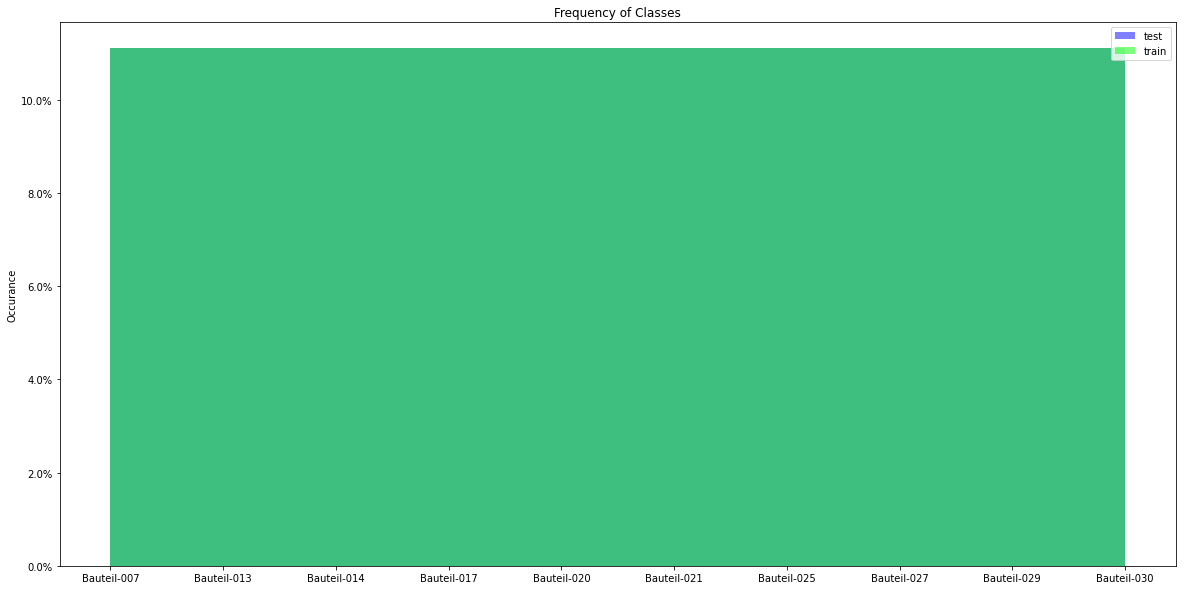

In [59]:
labels_1=np.asarray(test_labels)
labels_2=np.asarray(train_labels)
unique_1=np.unique(labels_1)
unique_2=np.unique(labels_2)
plt.ylabel('Occurance')
plt.title('Frequency of Classes')
hist1=plt.hist(labels_1,bins=len(unique_1),alpha=0.5, label="test", density=True, color=[0,0,1])
hist2=plt.hist(labels_2,bins=len(unique_2),alpha=0.5, label="train", density=True, color=[0,1,0])
# print(hist1)
plt.xticks(ticks=unique_1 ,labels=label_names)
plt.legend(loc='upper right')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

create .h5 file

In [60]:
f = h5py.File('10_2048data_train.h5', 'w')
dataset_points=f.create_dataset(name="data",shape=train_points.shape,dtype=np.dtype("float32"),data=train_points)
dataset_points=f.create_dataset(name="label",shape=train_labels.shape,dtype=np.dtype(int),data=train_labels)
f.close()

f = h5py.File('10_2048data_test.h5', 'w')
dataset_points=f.create_dataset(name="data",shape=test_points.shape,dtype=np.dtype("float32"),data=test_points)
dataset_points=f.create_dataset(name="label",shape=test_labels.shape,dtype=np.dtype(int),data=test_labels)
f.close()

In [3]:
f = h5py.File("ml_radius-0_noise-0_view-0_batch-0_size-0_variation-1_test_.h5", 'r+')
data = f['data'][:].astype('float32')
label = f['label'][:].astype('int64')
print(data.shape)
print(label.shape)
print(label)
f.close()

(168, 1024, 3)
(168,)
[14 18 10 11  1 23 21 12  0 19  9  0  4  8  7 16 23 12  4 20  5 18  4 13
 19 10  0  9  5  8  9 19  5  2  5  0  3  2 14 14 18 19 11  7 23  6 13  0
 12 11  9 10  7 18  1 14 20  7  3 21 15 20 21  1 10 17 11 11 16  3 22  5
  9  1 17 18  4 13 17 13 16  4  2 23 21  8  3 17 11  7 16 10 15 21 19 13
  0  2  2  9  5 13  7 12 12 21 20  3 14 22 20  1 20 14  8 22 22 16 16 23
 14 10  4 21  0 17 10  2  6  6  6 15  9  8  4  3 15  3 22 12 16 23 17 15
 15 23  1 18 22 20  2  1  6 12 19 13  8  7 11  8 17 22  6 18 15  5  6 19]


look at data

In [4]:
import open3d as o3d

In [5]:

i=np.random.randint(0,len(label))
# print(test_labels[i])
# print(label_names[int(test_labels[i])])
pcd = o3d.geometry.PointCloud()
pcd.points= o3d.utility.Vector3dVector(data[i])
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
